In [10]:
# --- Setup & robust data load ---
import os, sys, subprocess
import pandas as pd
import numpy as np

from plotnine import (
    ggplot, aes, geom_boxplot, coord_flip, labs, theme_minimal, theme, element_text,
    scale_x_discrete, geom_line, facet_wrap, scale_y_continuous, guides, guide_legend
)

In [11]:
data = "tr_data_22_24.csv"
df = pd.read_csv(data)

In [12]:
df.columns = [c.strip().lower() for c in df.columns]
df.head(3)

,site,mode,division,region,destination,shipping_date,invoice_date,usda_invoice_amount
0,US77,less_truck_load,NaN,EMEA,Amsterdam,2022-01-01,2022-01-27,715.603599
1,US62,std_air,F928,EMEA,Paris,2022-01-01,2022-01-02,368.346398
2,TH2E,full_container_load,E916,EMEA,Dubai,2022-01-01,2022-02-12,5605.915943


Question 1 — Delay Distribution by Mode
After our analysis in Question 5 of the second assignment, we now know that the delays between invoice and shipment dates are closely related to the specific transportation mode. Create a compelling visual of this finding with the following requirements:

A boxplot visualization of delay broken down by transportation mode (excluding NA values and the other categories), for which the boxplots are ordered based on delay (from largest delays to smallest delays)
Including refinements such as proper x- and y-axis titles and labels. You should also use a custom theme to increase your plot's data-to-ink ratio.

In [15]:
# Ensure required helpers and columns exist
from pathlib import Path

# column that contains transportation mode
mode_col = "mode"

# create delay_days if it doesn't exist
if "delay_days" not in df.columns:
    df["shipping_date"] = pd.to_datetime(df["shipping_date"])
    df["invoice_date"] = pd.to_datetime(df["invoice_date"])
    df["delay_days"] = (df["invoice_date"] - df["shipping_date"]).dt.days
# --- End Setup & robust data load ---


In [16]:
# Exclude NA and 'other' modes; order by median delay (desc)
plot_df = df.dropna(subset=[mode_col, "delay_days"]).copy()
# use case-insensitive comparison and guard against non-string values
plot_df = plot_df[~plot_df[mode_col].astype(str).str.lower().eq("other")]

order = (
    plot_df.groupby(mode_col)["delay_days"].median()
    .sort_values(ascending=False).index.tolist()
)
plot_df[mode_col] = pd.Categorical(plot_df[mode_col], categories=order, ordered=True)

p_delay = (
    ggplot(plot_df, aes(x=mode_col, y="delay_days"))
    + geom_boxplot(outlier_alpha=0.35, width=0.6)
    + coord_flip()
    + labs(
        title="Invoice–Shipment Delay by Transportation Mode",
        x="Transportation Mode (ordered by median delay)",
        y="Delay (days)"
    )
    + theme_minimal()
    + theme(
        figure_size=(8, 5),
        panel_grid_minor=element_text(alpha=0),
        panel_grid_major=element_text(alpha=0.25),
        axis_title=element_text(size=11),
        axis_text=element_text(size=10),
        plot_title=element_text(size=12, weight="bold")
    )
)
# ensure output folder exists
PLOTS = Path("plots")
PLOTS.mkdir(parents=True, exist_ok=True)

q1_path = PLOTS / "delay_dist_by_mode.png"
p_delay.save(str(q1_path), dpi=300)
q1_path

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 8 x 5 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\delay_dist_by_mode.png


WindowsPath('plots/delay_dist_by_mode.png')

In [17]:
q1_path.exists()

True

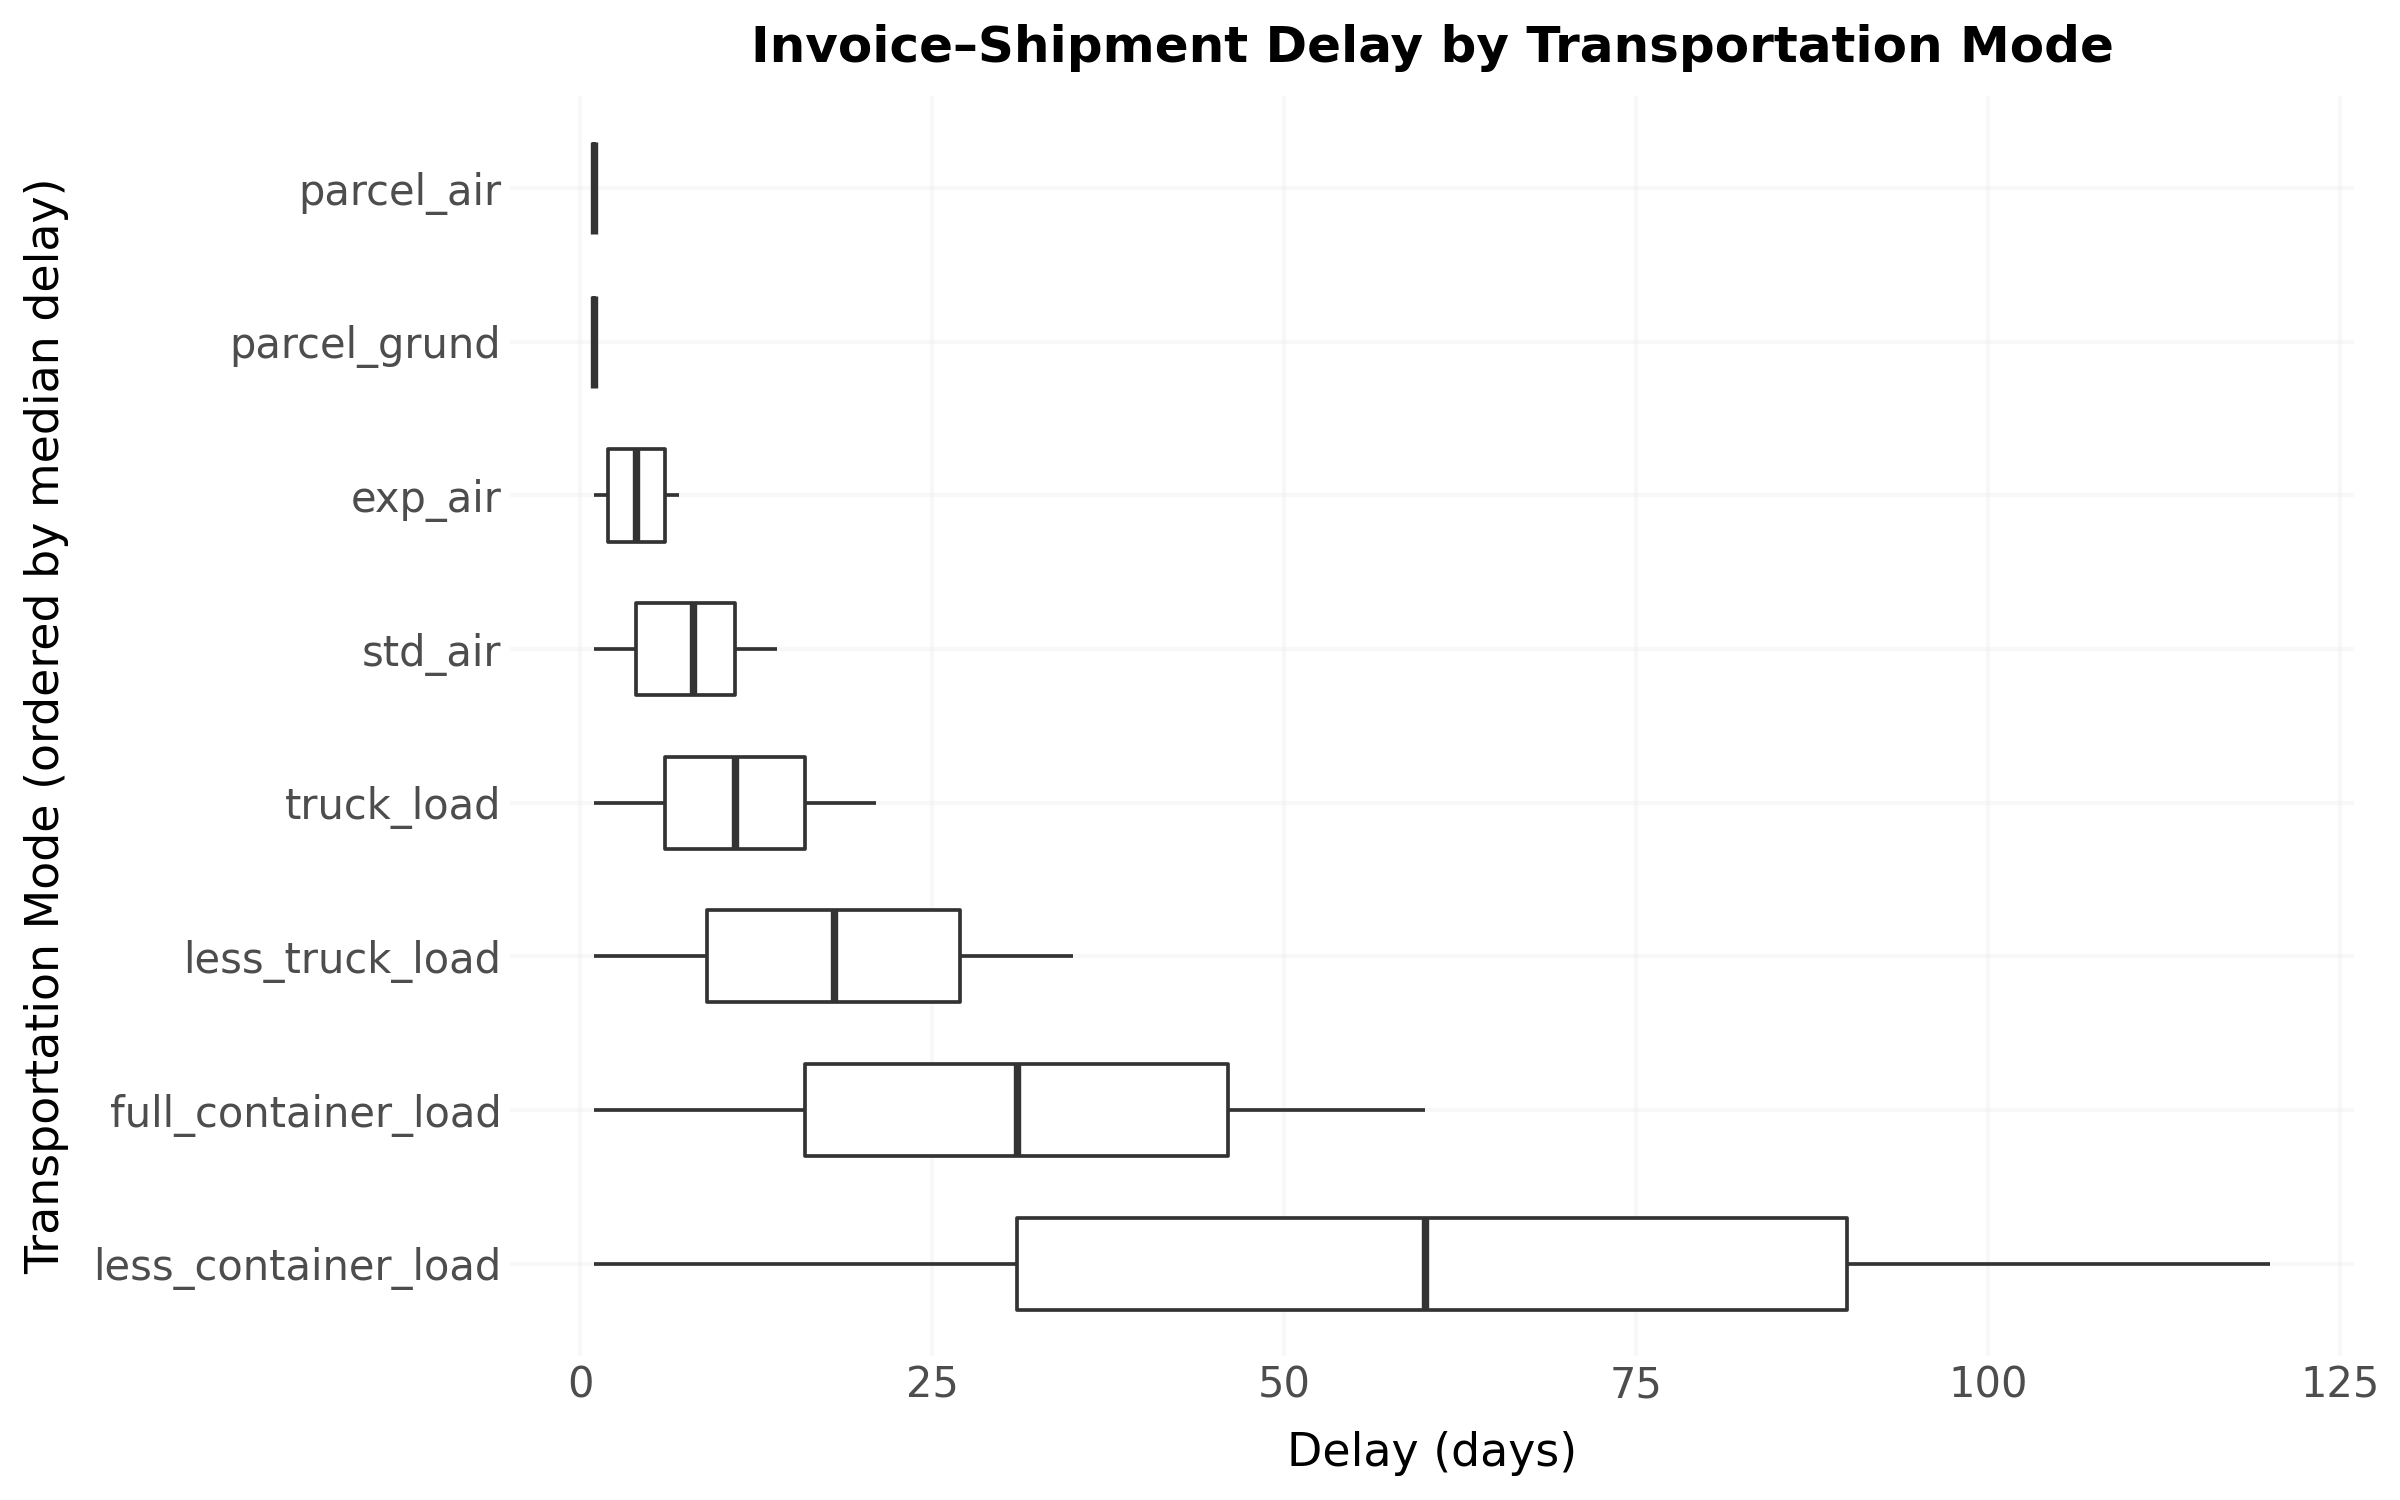

In [18]:
from IPython.display import Image, display
display(Image(filename=str(q1_path)))

Question 2 — Invoice Time Series
With the delay distribution analysis complete, we can finally focus on the invoice time series data and investigate any possible patterns (seasonality, trend, or both) that might help us with our estimation and forecasting tasks.

Create a visualization of the time series of invoice amounts by shipping date. Explain why this initial visualization is not suitable for our analysis.

Suggest and create another visualization that performs better than the initial visualization. Hint: You may need to create small multiples to get a better picture of invoice time series data.

In [20]:
# --- prepare invoice time-series data ---
shipping_col = "shipping_date"
amount_col   = "invoice_amount"
mode_col     = "transportation_mode"

# If invoice_amount doesn't exist, fall back to usda_invoice_amount (preserves downstream name)
if amount_col not in df.columns and "usda_invoice_amount" in df.columns:
    df[amount_col] = df["usda_invoice_amount"]

# aggregate by day
daily = (
    df.groupby(df[shipping_col])[[amount_col]]
      .sum()
      .reset_index()
      .rename(columns={shipping_col: "shipping_date", amount_col: "invoice_amount"})
      .sort_values("shipping_date")
)
daily.head()

,shipping_date,invoice_amount
0,2022-01-01,1.262726e+06
1,2022-01-02,9.674928e+05
2,2022-01-03,8.986529e+05
3,2022-01-04,9.387058e+05
4,2022-01-05,9.776208e+05


In [21]:
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, theme, element_text

p_initial = (
    ggplot(daily, aes("shipping_date", "invoice_amount"))
    + geom_line(size=0.6)
    + labs(
        title="Invoice Amounts by Shipping Date (Daily Totals)",
        x="Shipping Date",
        y="Invoice Amount (USD)"
    )
    + theme_minimal()
    + theme(
        figure_size=(9, 4.5),
        panel_grid_minor=element_text(alpha=0),
        panel_grid_major=element_text(alpha=0.25),
        axis_title=element_text(size=11),
        axis_text=element_text(size=9),
        plot_title=element_text(size=12, weight="bold")
    )
)

# display inline
p_initial

# save png
from pathlib import Path
PLOTS = Path.cwd().parent / "plots" if Path.cwd().name == "notebooks" else Path("plots")
q2_initial_path = PLOTS / "invoice_ts_initial.png"
p_initial.save(str(q2_initial_path), dpi=300, width=9, height=4.5, units="in")
q2_initial_path.resolve()

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 9 x 4.5 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\invoice_ts_initial.png


WindowsPath('C:/Users/Hardi/OneDrive - California State University San Marcos/CSUSM/OM-621/Assignments/plots/invoice_ts_initial.png')

In [24]:
list(Path(".").rglob("invoice_ts_initial.png"))

[WindowsPath('plots/invoice_ts_initial.png')]

In [26]:
p_initial.save(str(PLOTS / "invoice_ts_initial.png"), dpi=300, width=9, height=4.5, units="in")

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 9 x 4.5 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\invoice_ts_initial.png


Improve visualization by mode (Monthly aggregation and small multiples)

In [23]:
# Robustly select mode column (handle different possible names)
if mode_col in df.columns:
    use_mode = mode_col
elif "mode" in df.columns:
    use_mode = "mode"
elif "transportation_mode" in df.columns:
    use_mode = "transportation_mode"
else:
    raise KeyError("No transportation mode column found. Expected one of: 'mode', 'transportation_mode'.")

work = df[[shipping_col, amount_col, use_mode]].copy()
# drop rows with missing mode or amount
work = work.dropna(subset=[use_mode, amount_col])

work["month"] = work[shipping_col].values.astype("datetime64[M]")

monthly_mode = (
    work.groupby([use_mode, "month"], as_index=False)[amount_col]
        .sum()
        .rename(columns={amount_col: "invoice_amount"})
        .sort_values([use_mode, "month"])
)

p_facets = (
    ggplot(monthly_mode, aes("month", "invoice_amount"))
    + geom_line(size=0.6)
    + facet_wrap(f"~ {use_mode}", scales="free_y", ncol=2)
    + labs(
        title="Monthly Invoice Amounts by Transportation Mode",
        x="Month",
        y="Invoice Amount (USD)"
    )
    + theme_minimal()
    + theme(
        figure_size=(10, 7),
        panel_grid_minor=element_text(alpha=0),
        panel_grid_major=element_text(alpha=0.25),
        axis_title=element_text(size=11),
        axis_text=element_text(size=9),
        strip_text=element_text(size=10, weight="bold"),
        plot_title=element_text(size=12, weight="bold")
    )
)

# show and save
p_facets
q2_final_path = PLOTS / "invoice_ts_small_multiples.png"
p_facets.save(str(q2_final_path), dpi=300, width=10, height=7, units="in")
q2_final_path.resolve()

c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 10 x 7 in image.
c:\Users\Hardi\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: plots\invoice_ts_small_multiples.png


WindowsPath('C:/Users/Hardi/OneDrive - California State University San Marcos/CSUSM/OM-621/Assignments/plots/invoice_ts_small_multiples.png')

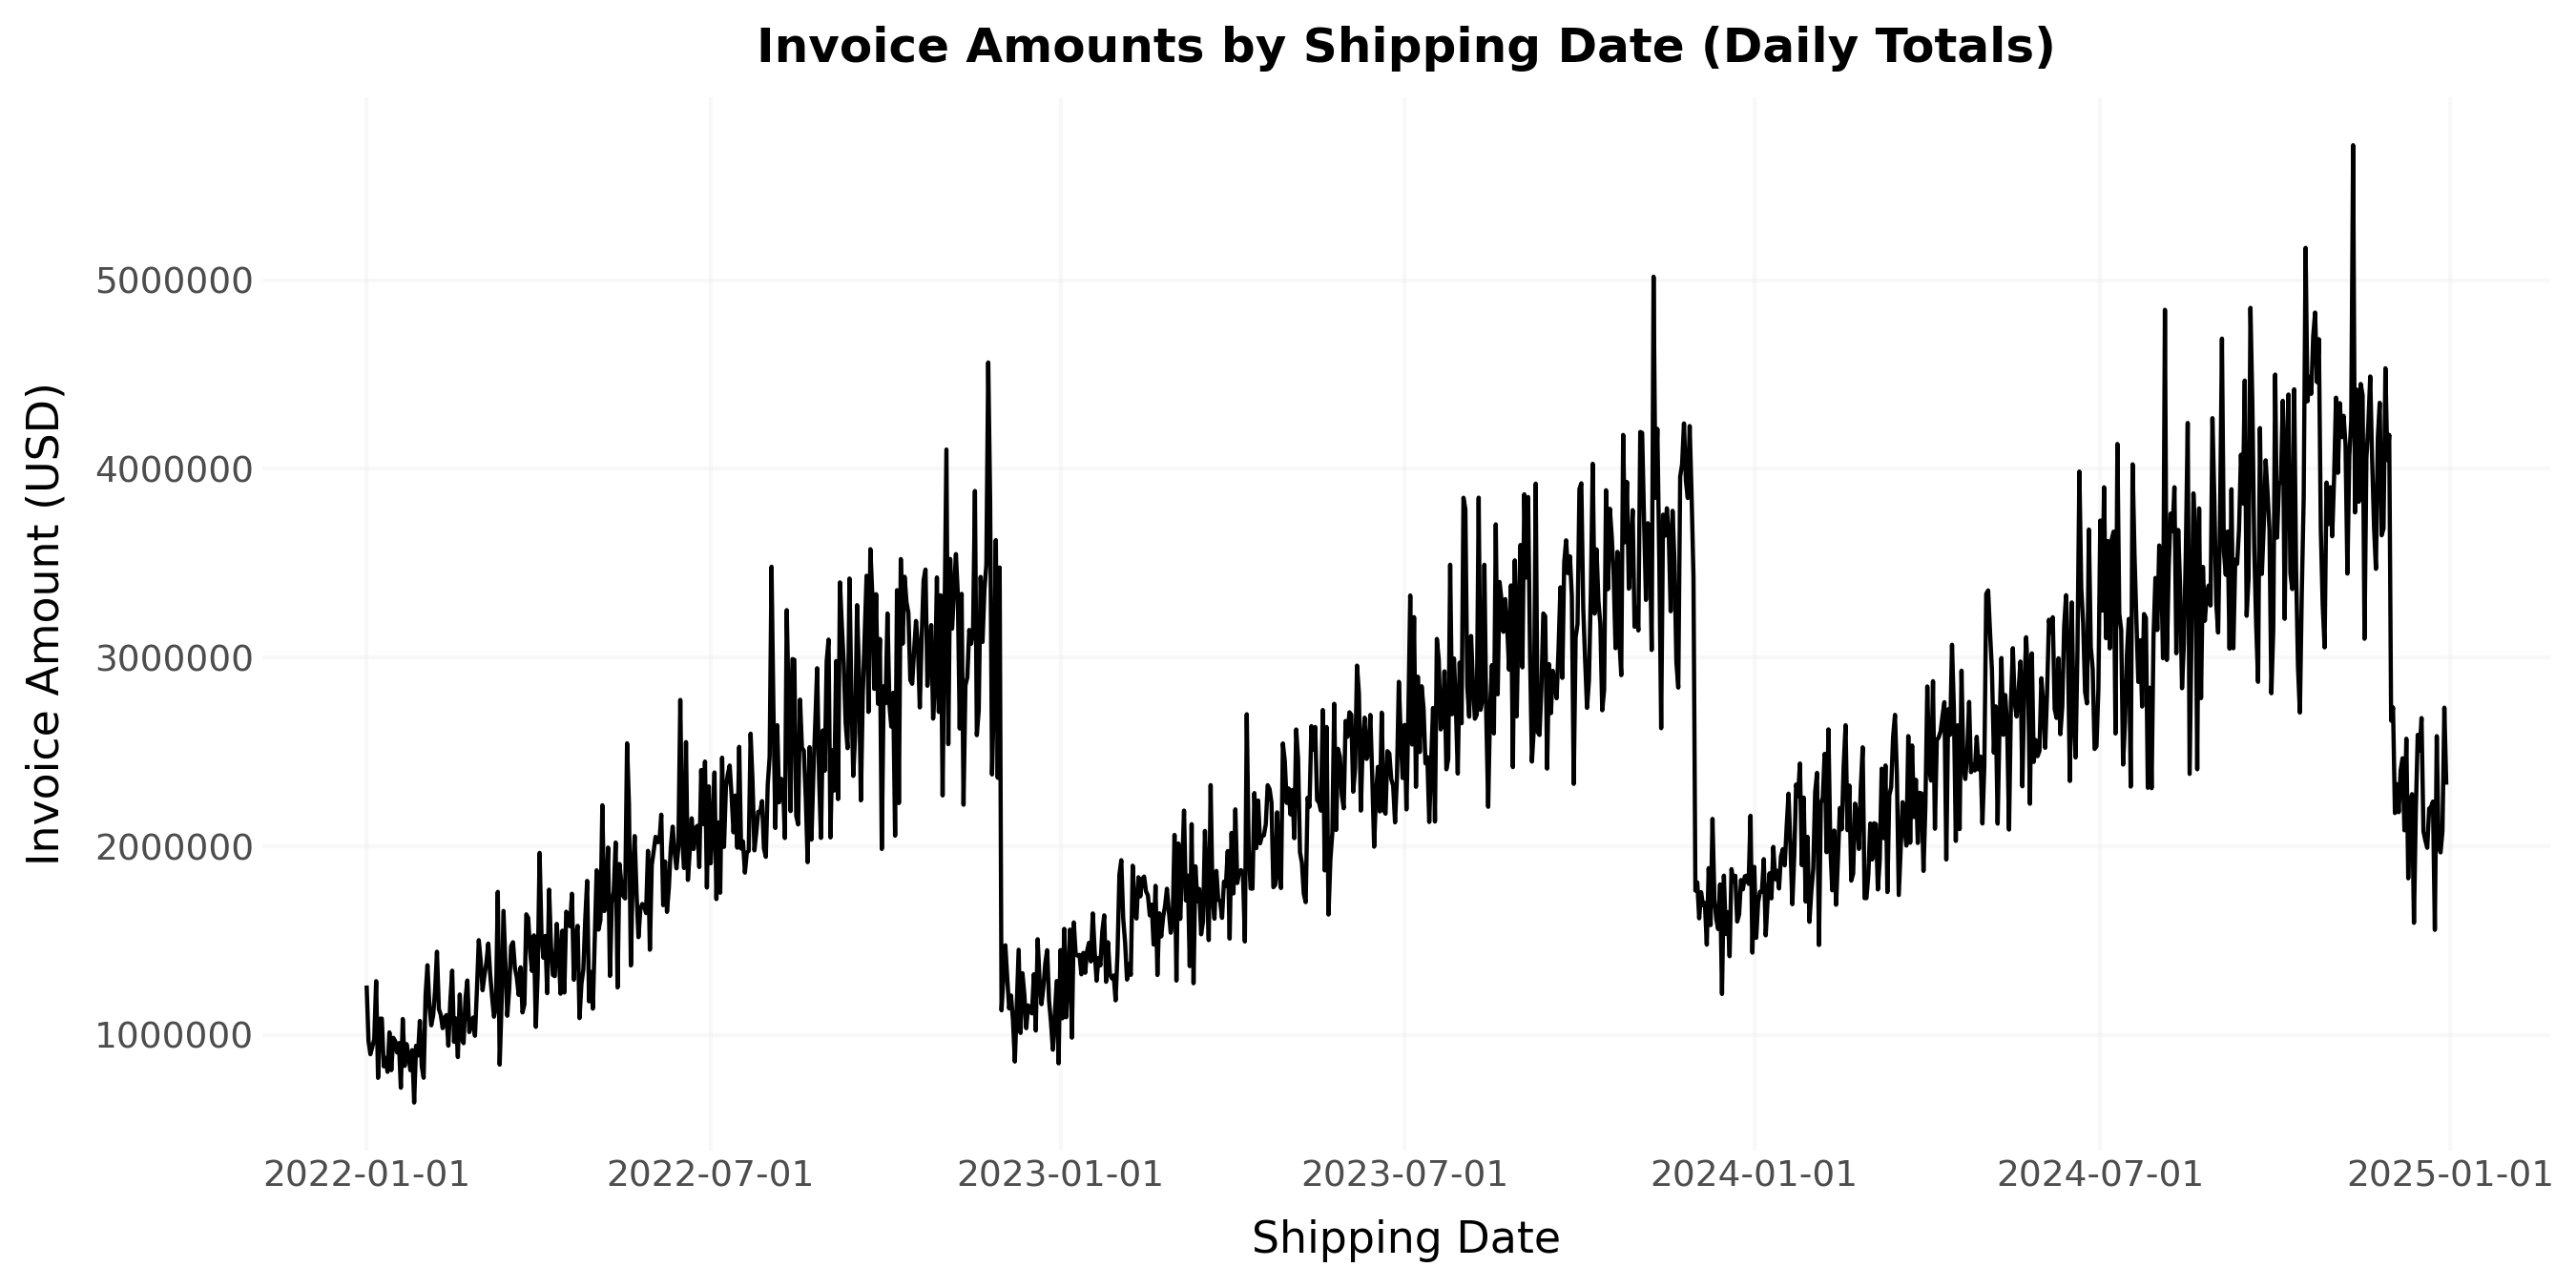

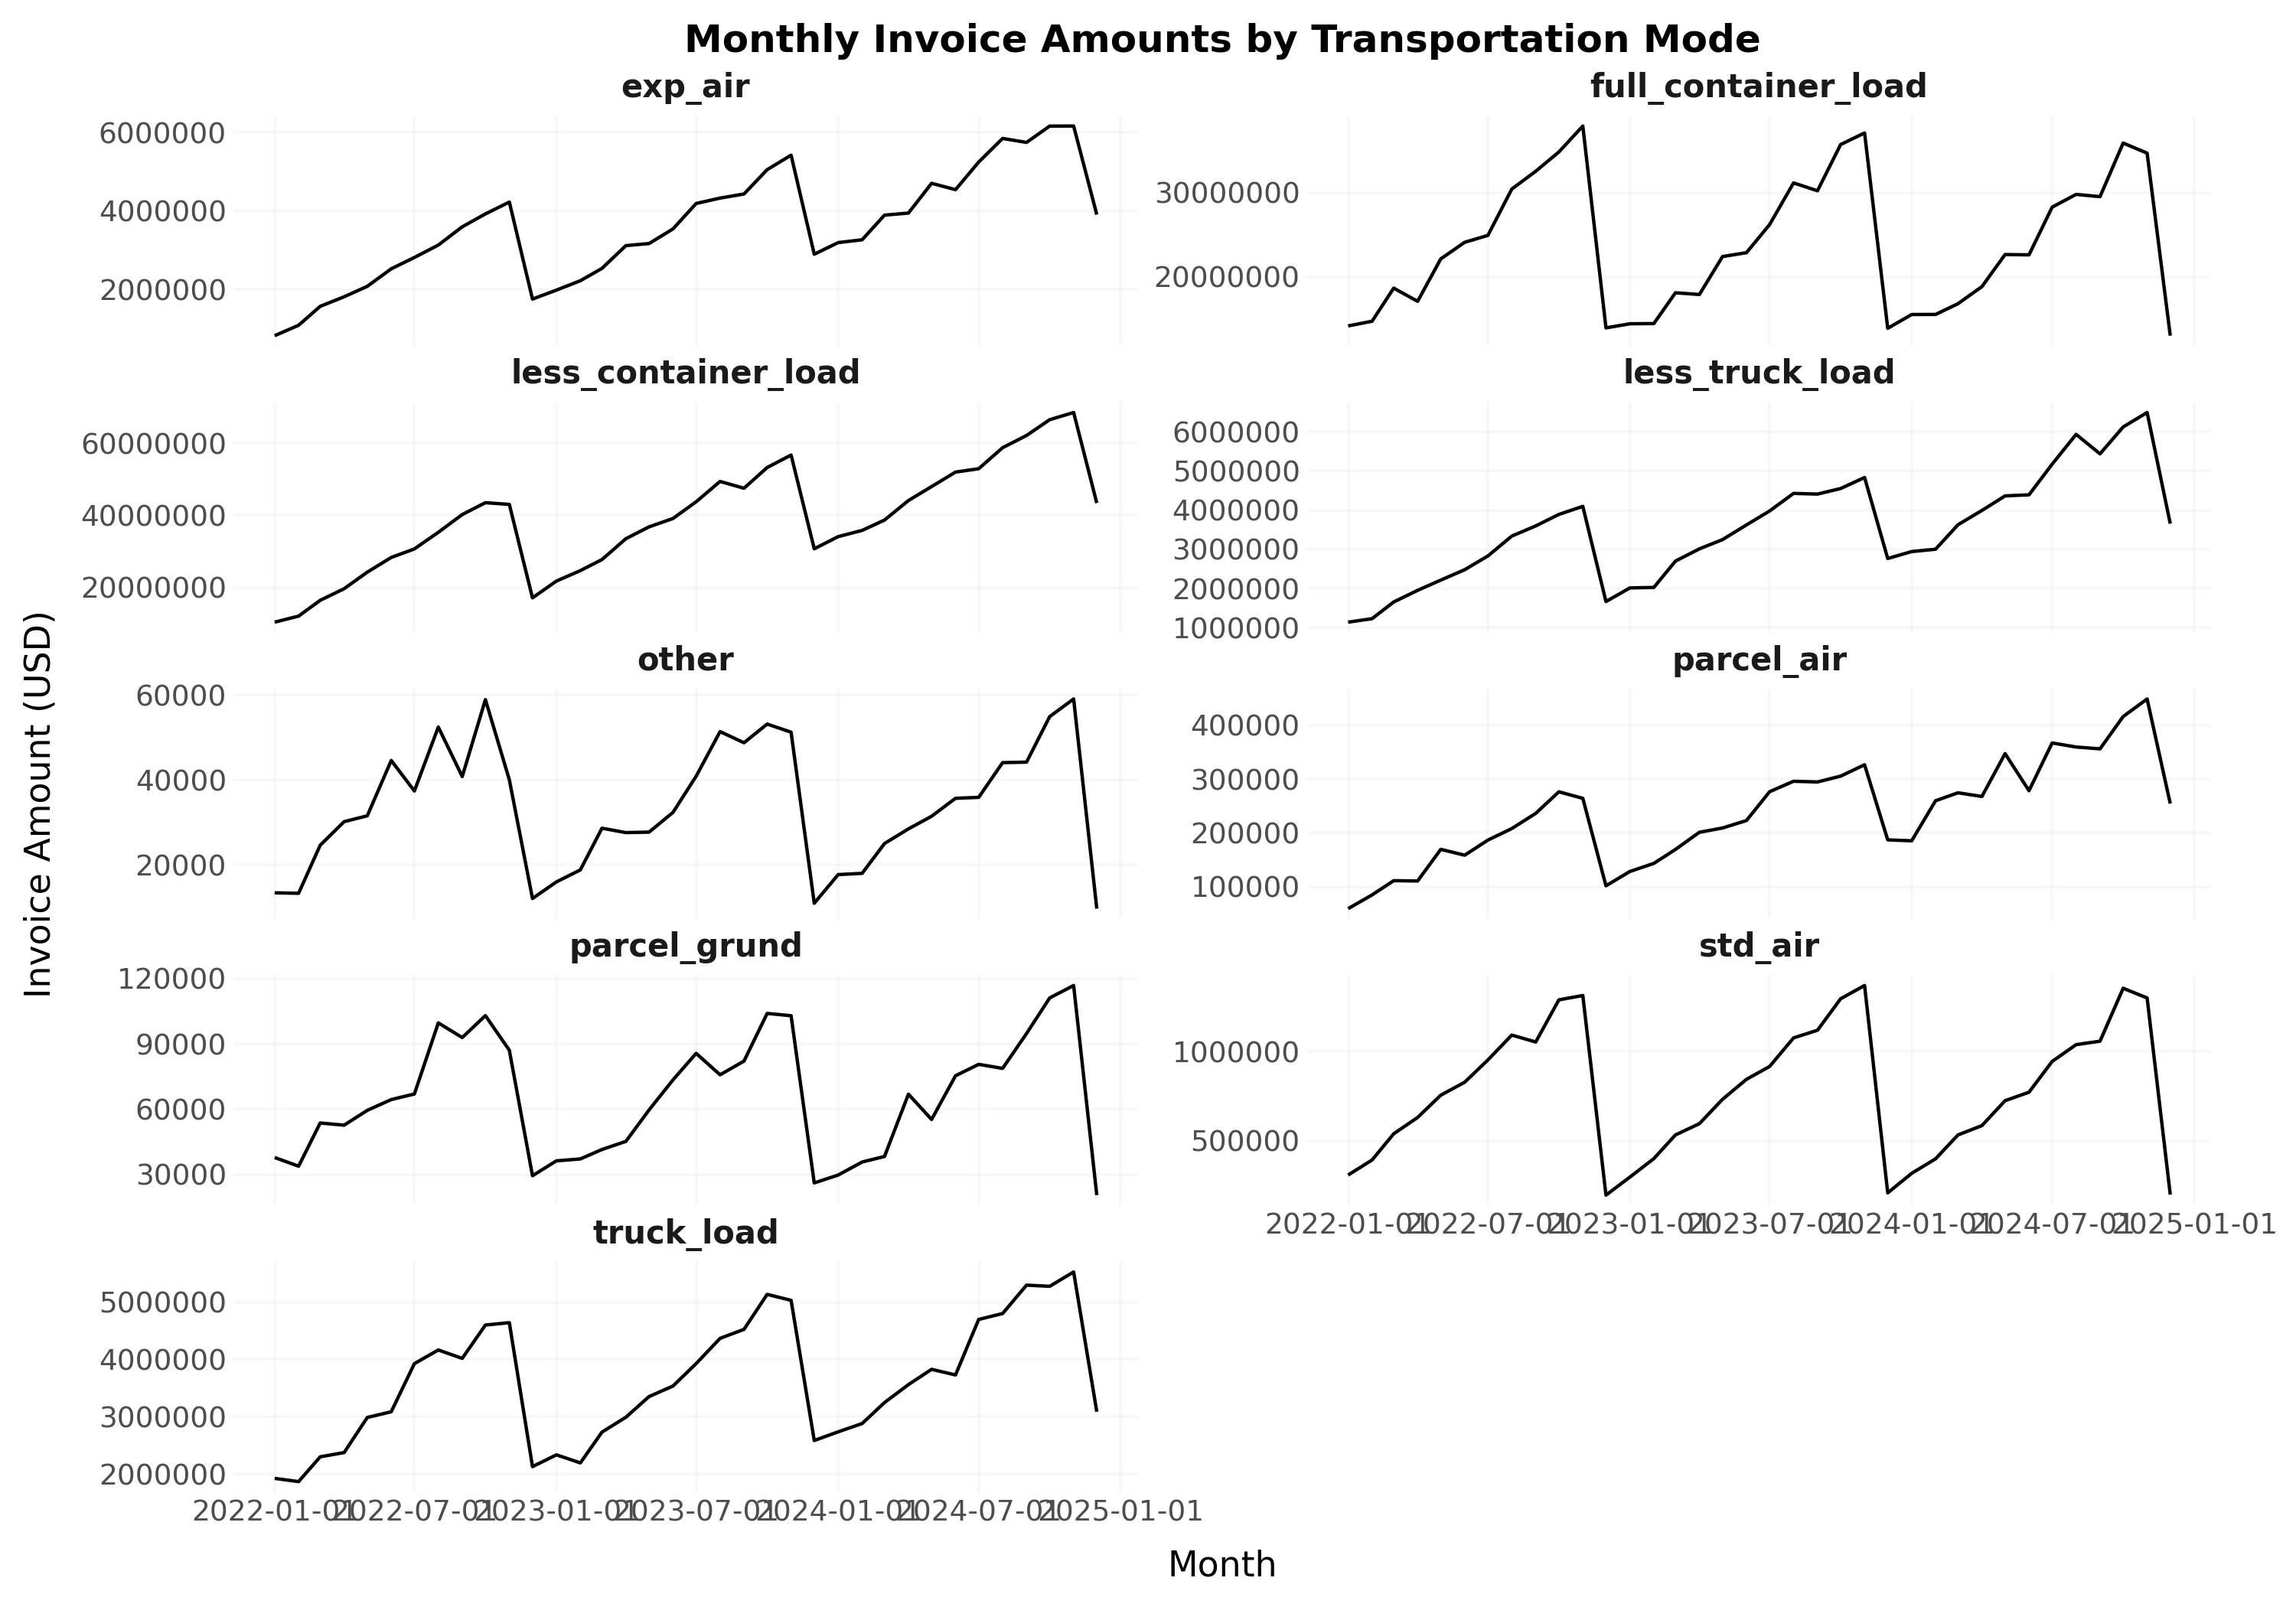

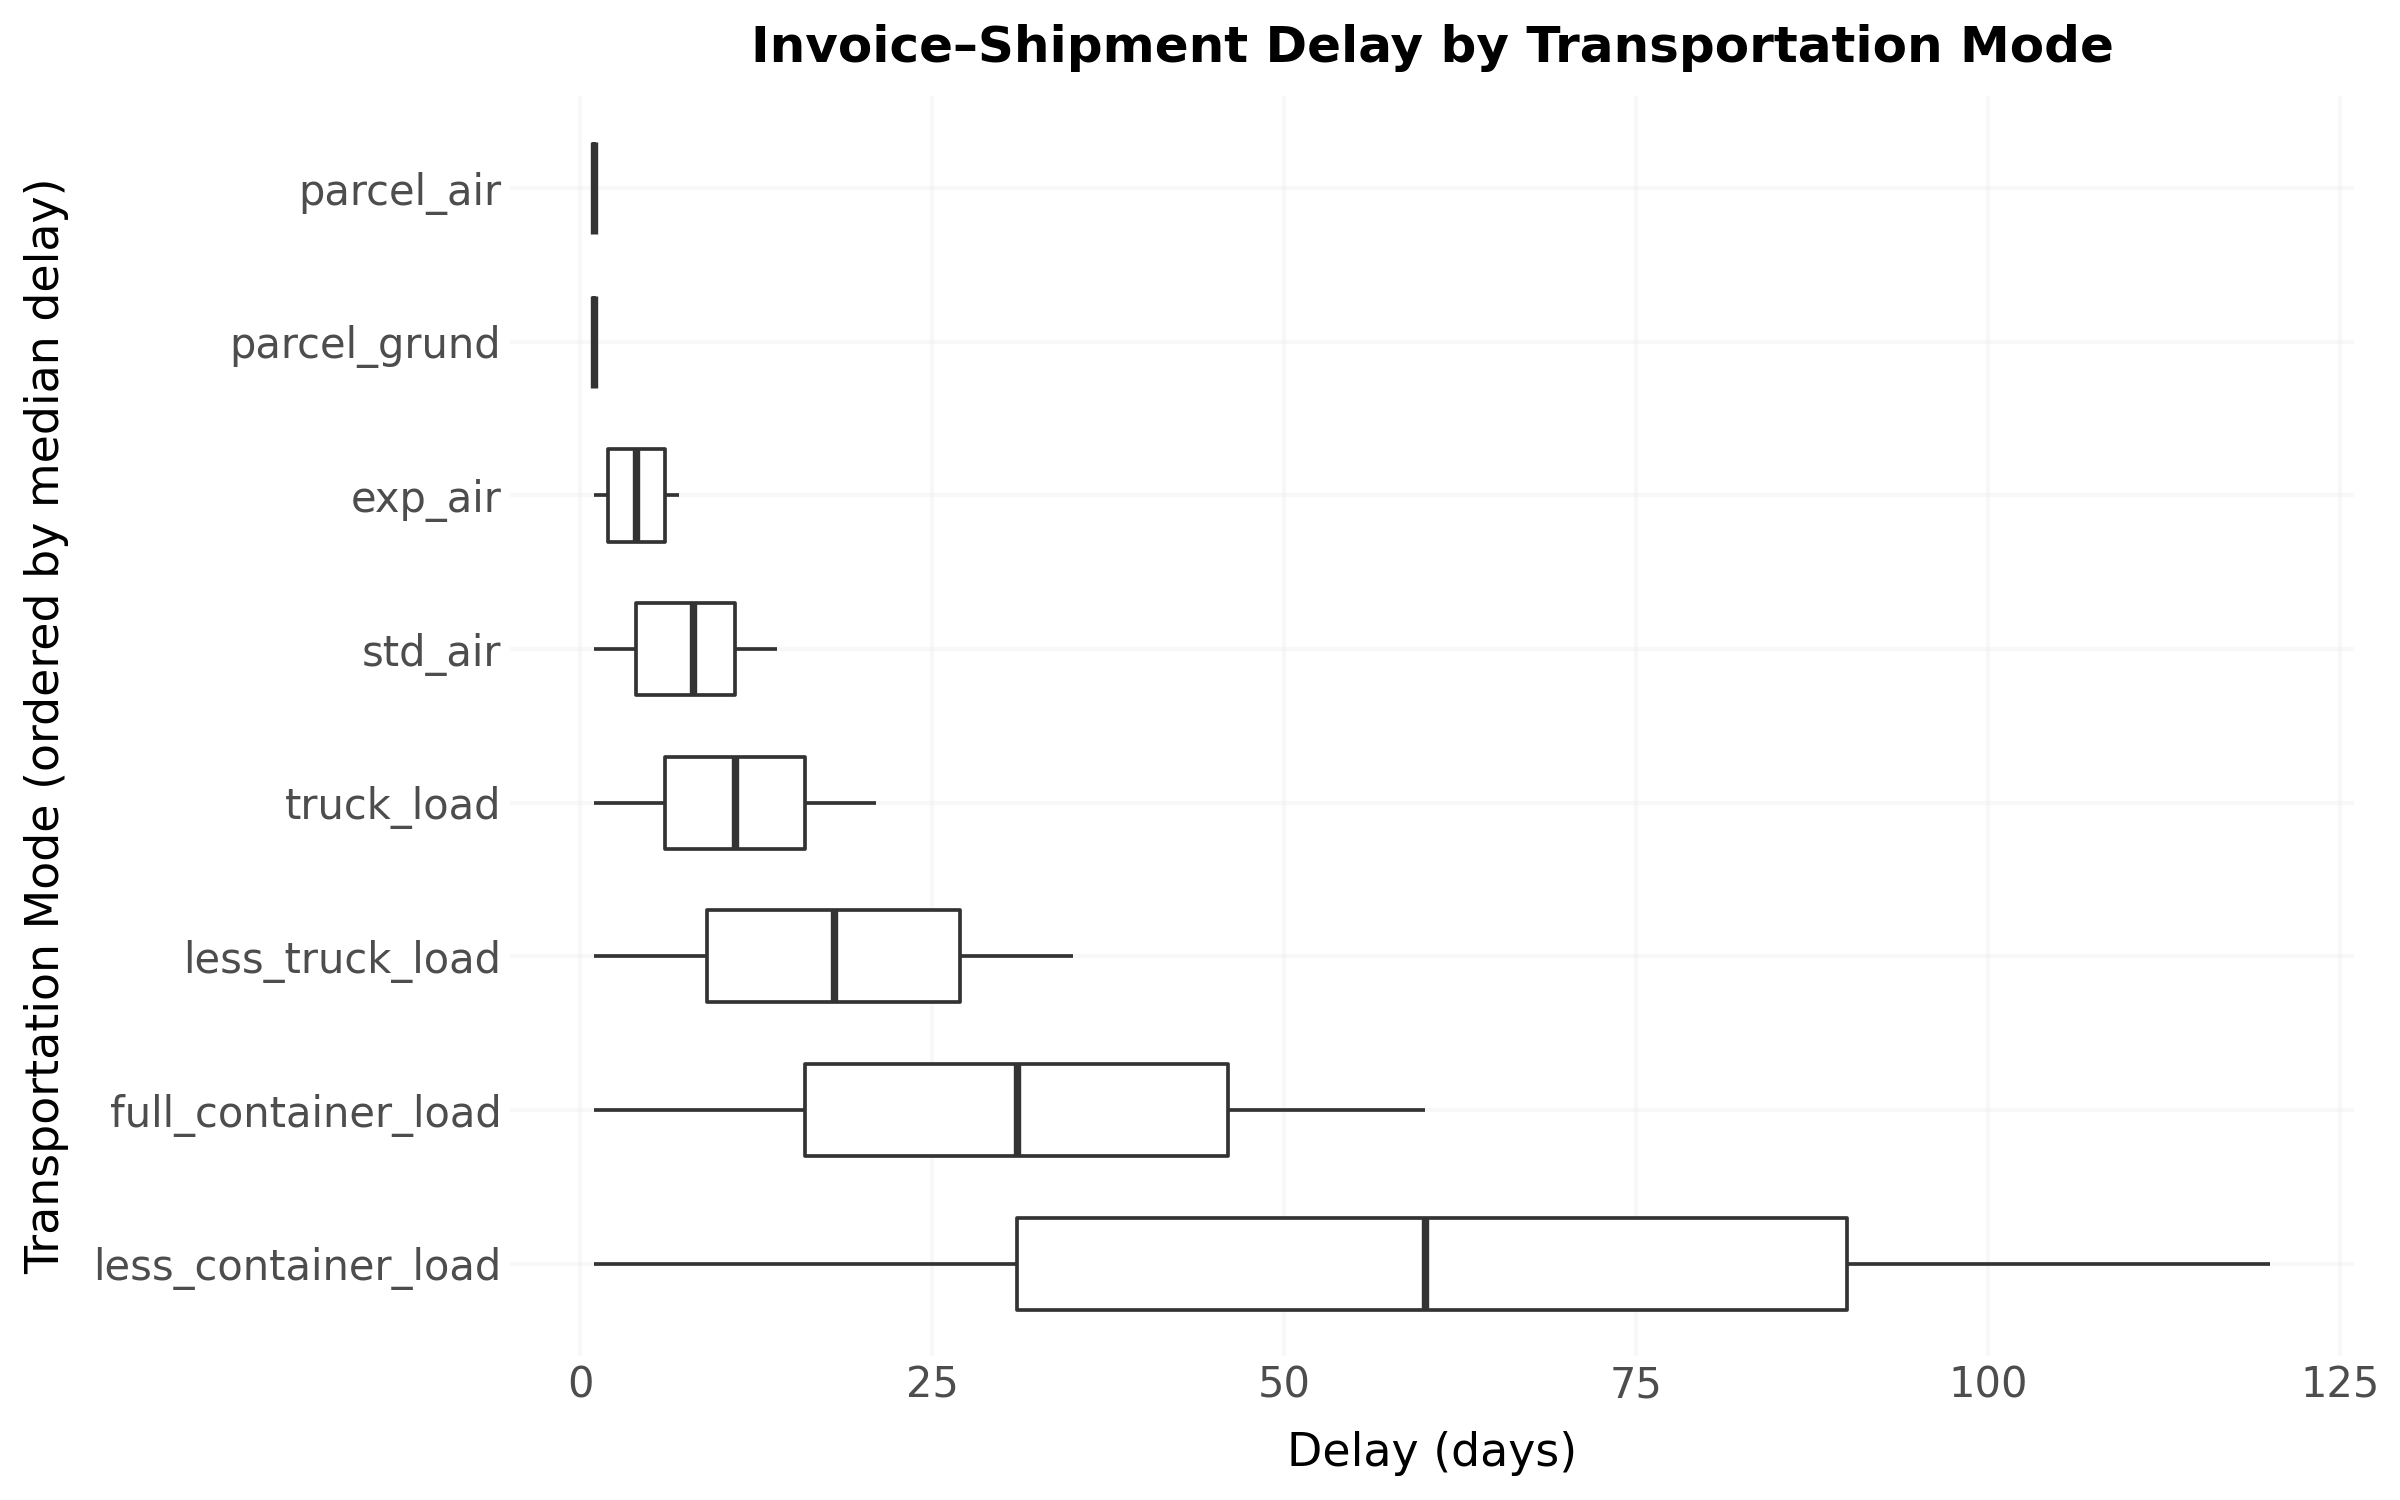

In [31]:
from IPython.display import Image, display

# display saved plots if they exist
for path in (q2_initial_path, q2_final_path, q1_path):
    if path.exists():
        display(Image(filename=str(path)))
    else:
        print(f"Missing: {path}")

The daily time series of invoice amounts demonstrates significant volatility and clutter. The frequent fluctuations make it difficult to discern overall seasonality or long-term trends. Additionally, when multiple transportation modes are used at the same time, aggregating the data daily mixes these modes together, resulting in a visualization that is not suitable for accurate forecasting.

The final monthly visualization beautifully highlights seasonal trends and specific transportation modes in invoicing. This enhanced perspective gives us valuable insights for precise cost estimation and forecasting, showcasing which modes contribute to periodic changes or consistency in invoice amounts.

Question 3 — Cost Estimation and Forecasting
What can you conclude regarding the existing time-series patterns in the invoice amounts? How can these patterns help estimate or forecast transportation costs? Do these patterns differ by transportation mode? Please be sure to elaborate on your response.

**Observed Time-Series Patterns**

The invoice time series shows clear seasonal and trend behaviors in transportation costs:

- Seasonality:Annual peaks indicate predictable fluctuations related to production cycles, inventory restocking, and consumer demand (e.g., holidays or fiscal quarter-ends).

- Trend:From 2022 to 2024, invoice amounts are rising steadily, suggesting either increased volume or inflation driving costs across transportation modes.

- Volatility:While overall trends are stable, short-term variations indicate potential operational disruptions or demand spikes (such as port congestion or severe weather).

**Differences by Transportation Mode/Cost behaviors vary by transportation mode:**

- Full Container Load (FCL) and Less Container Load (LCL): These modes experience strong seasonality and account for the highest invoice amounts, making them key for forecasting.

- Truck Load (TL) and Less Truck Load (LTL): These modes show consistent growth with smaller seasonal changes, reflecting stable domestic distribution costs.

- Air Modes (Express Air, Standard Air, Parcel Air): These modes have erratic spikes and quick recoveries, driven by urgent demand and premium pricing.

- Parcel Modes: They exhibit lower costs but stable behaviors, indicating predictable low-cost patterns.

**Implications for Cost Estimation**

- Seasonal Factors: Incorporate month-of-year or quarterly indicators in cost models for each transportation mode to capture recurring invoice peaks.

- Trend Components: Rising costs imply ongoing increases. Forecasting models should integrate trend and seasonal components.

- Mode Segmentation: Different models for each mode will yield better results than a single aggregate model.

**Forecasting Application:** 
Using aggregate monthly forecasts for quarterly budgets and mode-specific predictions for better carrier negotiations and capacity planning. Rolling 3- or 6-month averages can stabilize short-term budget forecasts.


**References:**

Karimi, M. (2025). OM-621: Business Forecasting and Data Analytics [Lecture materials and assignment brief].  

Microsoft. (2025). Visual Studio Code [Computer software]. Retrieved from https://code.visualstudio.com/  

OpenAI. (2025). ChatGPT [Large language model; conversation with the author on October 10, 2025]. Retrieved from https://chat.openai.com/


Plotnine Project (2025). Plotnine: A Grammar of Graphics for Python [Documentation]. Retrieved from https://plotnine.org/reference/